## OOR reference design benchmark - compare DA methods

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import glob
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [3]:
from oor_benchmark.metrics import auprc, FDR_TPR_FPR

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [9]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

In [10]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_DAmethods/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [11]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

## Run reference design comparison and parse results

See `submit_oor_design_v2.sh`

## Read outputs

In [12]:
def _read_oor_design(simdir, res_type = 'AUPRC', diff_method = 'meld'):
    res_file = glob.glob(f'{simdir}/{res_type}_res.{diff_method}.csv')
    assert len(res_file) == 1
    r = pd.read_csv(res_file[0], index_col=0)
    r['diff_method'] = diff_method
    return(r)

In [13]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_') and not x.endswith("withOOR") and not x.endswith(".pkl")]

In [14]:
AUPRC_df = pd.DataFrame()
for d in dirs:
    for m in ['meld', 'cna', 'milo']:
        try:
            r = _read_oor_design(outdir + d, diff_method=m)
            r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
        except AssertionError:
            continue
        AUPRC_df = pd.concat([AUPRC_df, r])

/tmp/ipykernel_29012/2816793471.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  r = r.drop(['Recall', "Precision"], 1).drop_duplicates()


In [15]:
TPR_df = pd.DataFrame()
for d in dirs:
    for m in ['meld', 'cna', 'milo']:
        try:
            r = _read_oor_design(outdir + d, res_type="TPR", diff_method=m)
#             r = r.drop(['Recall', "Precision"], 1).drop_duplicates()
        except AssertionError:
            continue
        TPR_df = pd.concat([TPR_df, r])

## Plot metrics

In [18]:
AUPRC_df['design'] = np.where(AUPRC_df['design'] == 'CR', AUPRC_df['design'].astype(str) + ' ' + AUPRC_df['embedding_method'].astype(str), AUPRC_df['design'])
TPR_df['design'] = np.where(TPR_df['design'] == 'CR', TPR_df['design'].astype(str) + ' ' + TPR_df['embedding_method'].astype(str), TPR_df['design'])

In [28]:
# Calculated for main PBMC design comparison analysis
no_sensitivity = ['CD14_low_CD16_positive_monocyte', 'conventional_dendritic_cell',
       'erythrocyte', 'mucosal_invariant_T_cell', 'plasmablast',
       'plasmacytoid_dendritic_cell', 'platelet', 'neutrophil']

In [29]:
AUPRC_df = AUPRC_df[~AUPRC_df['OOR_state_name'].isin(no_sensitivity)].copy()
TPR_df = TPR_df[~TPR_df['OOR_state_name'].isin(no_sensitivity)].copy()

In [32]:
TPR_df['OOR_state_name'].nunique()

8

In [30]:
%%R -i AUPRC_df -w 1000 -h 400
pl1 <- AUPRC_df %>%
    mutate(`DA method` = ifelse(diff_method == 'milo', 'Milo', toupper(diff_method))) %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", "CR scVI", 'ACR'))) %>%
    ggplot(aes(design, AUPRC, color=design)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    scale_color_brewer(palette='Accent', 
                       labels=c(logFC='DA logFC (ACR design)', 
                           mean_mappingQC_reconstruction = 'mean reconstruction mapping QC', 
                           mean_mappingQC_labels = 'mean label uncertainty mapping QC')) +
    theme_bw(base_size=24) +
    facet_grid(.~`DA method`, labeller='label_both') +
    scale_color_manual(values=design_palette) +
    theme_bw(base_size=24) +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
    ggsave(paste0(figdir, 'AUPRC_boxplot_design.png'), width=12, height=7) +
    ggsave(paste0(figdir, 'AUPRC_boxplot_design.pdf'), width=12, height=7)


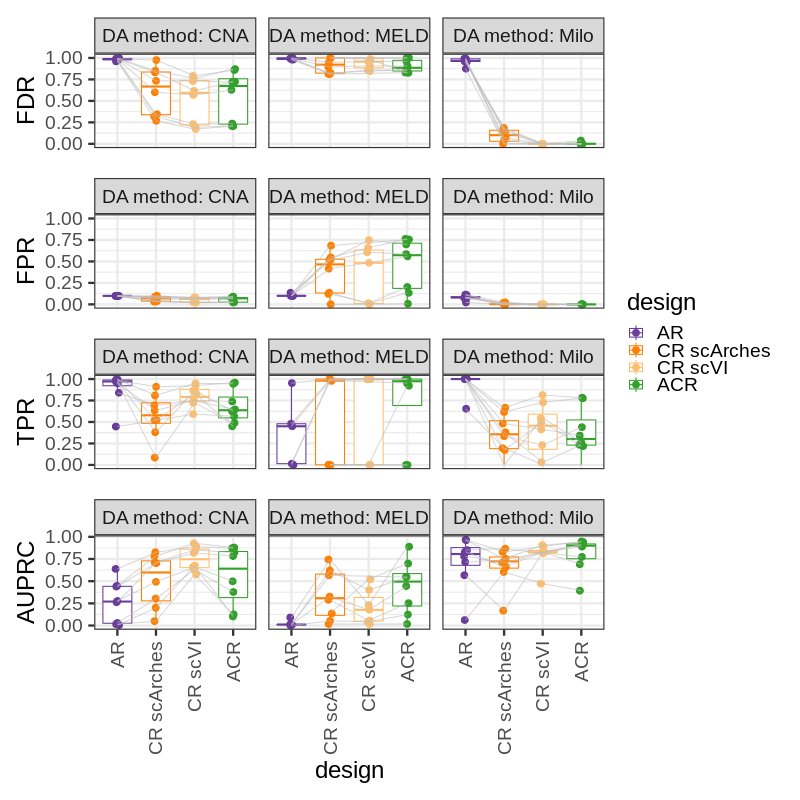

In [31]:
%%R -i TPR_df -w 800 -h 800
library(patchwork)

pl_df <- TPR_df %>%
    pivot_longer(cols=c("TPR", "FPR", "FDR"), names_to='metric') %>%
    mutate(`DA method` = ifelse(diff_method == 'milo', 'Milo', toupper(diff_method))) %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", "CR scVI", 'ACR'))) 

pl_ls <- lapply(c('FDR', "FPR", "TPR"), function(m) pl_df %>%
                filter(metric == m) %>%
                ggplot(aes(design, value, color=design)) +
                geom_boxplot() +
                geom_jitter(size=3, width=0.05) +
                geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
                scale_color_brewer(palette='Accent', 
                                   labels=c(logFC='DA logFC (ACR design)', 
                                       mean_mappingQC_reconstruction = 'mean reconstruction mapping QC', 
                                       mean_mappingQC_labels = 'mean label uncertainty mapping QC')) +
                theme_bw(base_size=24) +
                ylab(m) + ylim(0,1) +
                facet_grid(.~`DA method`, labeller='label_both') +
                scale_color_manual(values=design_palette) +
                theme_bw(base_size=24) +
                theme(
                    axis.title.x=element_blank(),
                    axis.text.x=element_blank(), axis.ticks.x=element_blank()))
pl_ls[['AUPRC']] <- pl1

wrap_plots(pl_ls) + plot_layout(ncol=1, guides='collect') +
    ggsave(paste0(figdir, 'metrics_boxplot_design.png'), width=12, height=15) +
    ggsave(paste0(figdir, 'metrics_boxplot_design.pdf'), width=12, height=15) 


---